In [1]:
data <- read.csv("APSfailure.csv", header = T, na.strings = c('NA','na'))

# Not shown is that I found that there are only two columns that don't contain NA's.


Split the data into X's and Y's momentarily so that I can operate on them separately.

In [2]:
Yfull <- data[,1]
Xfull <- data[,2:ncol(data)]

In [3]:
Yfull <- ifelse(Yfull == 'neg',0,1)

This following function is used to check how many unique entries are in a row or column, and will be used with the next apply function so that I can see if anything needs to be One Hot Encoded.

In [4]:
coun <- function(col){
    return(length(unique(col)))
}

This uses the above function to count how many unique values there are in each column.

In [5]:
uniques <- apply(Xfull, FUN = coun, MARGIN = 2)

This identifies which columns are completely filled with NA's or only one element and eliminates them from the dataset since we can't extract any value from them.

In [6]:
indlesstwo <- which(uniques<2)
Xfull<-Xfull[,-indlesstwo]

This identifies which remaining columns have less unique elements than three so I can One Hot Encode them.

In [7]:
nuniques <- apply(Xfull, FUN = coun, MARGIN = 2)
indlessthree <- which(nuniques < 3)


In [8]:
Xfull<-Xfull[,-indlessthree]


In [9]:
new <- cbind(Yfull,Xfull)

In [10]:
TVTsplit <- function(matrix, train = .7){
#     This function's purpose is to split a given matrix
#     into three parts: train, test, and validate. The 
#     train parameter is the percentage of the data that
#     goes into training 70% by default. The val parameter
#     determines how much goes into the validation set
#     15% by default. The rest of the data goes into
#     the test set.
    
    # The following does some common sense things like
    # telling you that train and val need to add up to less
    # than 1.
    if(train > .99){
        print("Splitting failed. Please make sure that
                train is less than .99 so that test and
                val have enough data.")
        return(0)
    }
    
    # This first line makes an index so that the data can
    # be subset randomly into two original sets: Train
    # and TestVal
    index <- sample(1:length(matrix[,1]),
                    round(length(matrix[,1])*train),
                    replace = FALSE)
    Train <- matrix[index,]
    TestVal <- matrix[-index,]
    
    # The next part splits TestVal into Test and Val.
    index <- sample(1:length(TestVal[,1]), 
                    round(length(TestVal[,1])*.5),
                    replace = FALSE)
    Val <- TestVal[index,]
    Test <- TestVal[-index,]
    
    # Please note that this returns a list of the 
    # three subsets.
    return(list(Train, Val, Test))
}

In [11]:
sets <- TVTsplit(new, .7)
train <- as.data.frame(sets[1])
val <- as.data.frame(sets[2])
test <- as.data.frame(sets[3])

In [12]:
mwona <- function(col){
    newcol <- na.omit(as.numeric(col))
    newcol[is.na(newcol)]<- mean(newcol, na.rm = TRUE)
}
trainmeans <- apply(train, MARGIN = 2,FUN = mwona)

Warning message in na.omit(as.numeric(col)):
“NAs introduced by coercion”

In [13]:
for(i in 1:ncol(train)){
    newtrain <- na.omit(train[,i])
    train[,i]<-as.numeric(train[,i])
    val[,i]<-as.numeric(val[,i])
    test[,i]<-as.numeric(test[,i])
    train[,i][is.na(train[,i])] <- mean(as.numeric(newtrain[i]))
    val[,i][is.na(val[,i])] <- mean(as.numeric(newtrain[i]))
    test[,i][is.na(test[,i])] <- mean(as.numeric(newtrain[i]))
}

In [16]:
Xtrain <-train[,2:ncol(train)]
Ytrain <-train[,1]

Xval <- val[,2:ncol(val)]
Yval <- val[,1]

Xtest <- test[,2:ncol(test)]
Ytest <- test[,1]
write.csv(Xtrain, "Xtrain.csv",row.names = FALSE)
write.csv(Ytrain, "Ytrain.csv",row.names = FALSE)
write.csv(Xval,"Xval.csv",row.names = FALSE)
write.csv(Yval,"Yval.csv",row.names = FALSE)
write.csv(Xtest,"Xtest.csv",row.names = FALSE)
write.csv(Ytest,"Ytest.csv",row.names = FALSE)

In [15]:
phitrain <- cbind(rep(1,nrow(Xtrain)),Xtrain)
phival <- cbind(rep(1,nrow(Xval)),Xval)
phitest <- cbind(rep(1,nrow(Xtest)),Xtest)

In [16]:
w <- as.matrix(rnorm(ncol(phitrain)))

In [17]:
sig<-function(matrix){
    return(1/(1+exp(-matrix)))
}

In [18]:
for(i in 1:ncol(phitrain)){
    phitrain[,i]<-as.numeric(phitrain[,i])
    phival[,i]<-as.numeric(phival[,i])
    phitest[,i]<-as.numeric(phitest[,i])
#     print(is.numeric(phitrain[,i]))
}
phitrain<-as.matrix(phitrain)
phival<-as.matrix(phival)
phitest<-as.matrix(phitest)

In [19]:
trainmaxs <- apply(phitrain,FUN = max, MARGIN = 2)
trainmins<- apply(phitrain, FUN = min, MARGIN = 2)

In [20]:
for(i in 2:ncol(phitrain)){
    phitrain[,i]<-(phitrain[,i] - trainmaxs[i])/(trainmaxs[i]-trainmins[i])
    phival[,i]<-(phival[,i] - trainmaxs[i])/(trainmaxs[i]-trainmins[i])
    phitest[,i]<-(phitest[,i] - trainmaxs[i])/(trainmaxs[i]-trainmins[i])
}


In [21]:
w<-as.matrix(rnorm(ncol(phitrain)))


[1] 0.8894737

[1] 0.9290351

[1] 0.9437229

[1] 0.9351754

[1] 2628.631

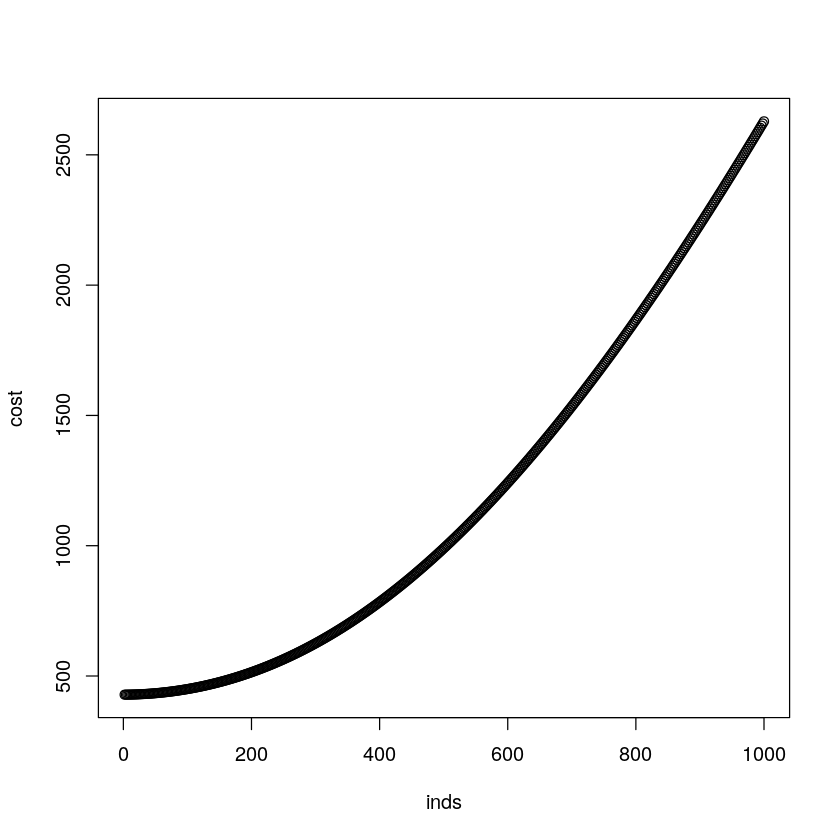

In [89]:
cost<-c()
inds<-c()
acclist <- c()
# costbest<- 100000000
w<-wbest
for(i in 1:1000){
    w<-w - .000000001*t(phitrain)%*%(sig(phitrain%*%w) - Ytrain)-600*sign(w) - .00001*w
    r<-ifelse(Yval == 1,-log(sig(phival%*%w)),-log(1-sig(phival%*%w)))
    acc<-mean(round(sig(phival%*%w))==Yval)
    acclist<- c(acclist,acc)
    cost<-c(cost,sum(r))
    inds<- c(inds,i)
    if(sum(r) < costbest){
        costbest<- sum(r)
        wbest<-w
    }
    
    
}
plot(inds,cost)
sum(round(sig(phival%*%w))*Yval)/sum(Yval)
acc
sum(round(sig(phitest%*%w))*Ytest)/sum(Ytest)
mean(round(sig(phitest%*%w))==Ytest)
sum(r)

In [109]:
# sum((sig(phitest%*%w)>.7)*!Ytest)/sum(Ytest==0)

[1] 0.01831011

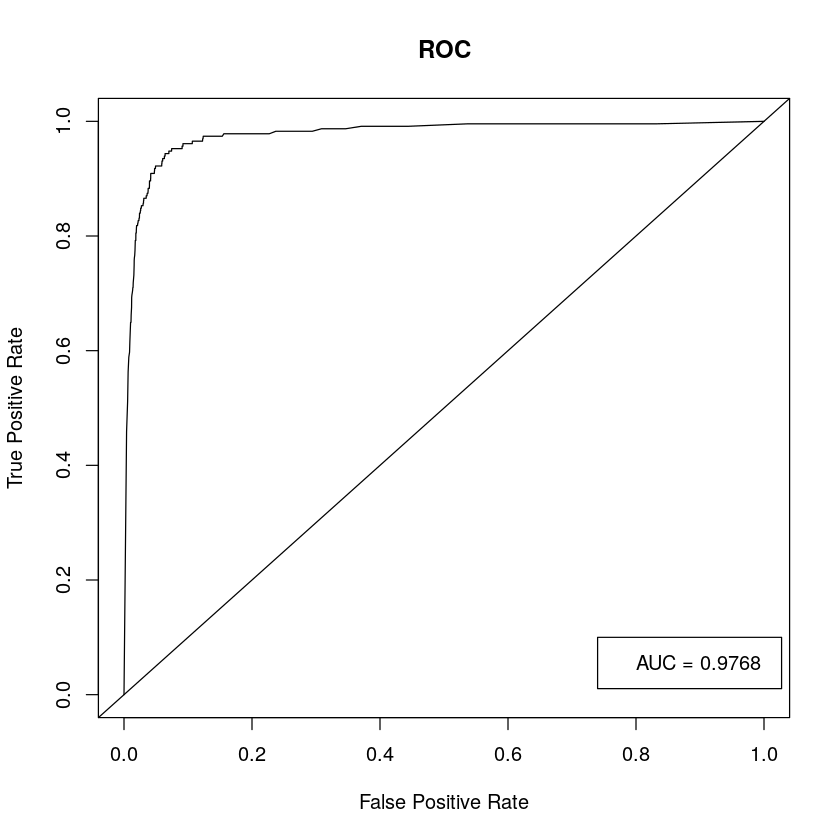

In [90]:
ROC<- function(X, Y, w){
    threshold<- 0:1000
    threshold<- rev(threshold/1000)
    tprs<-c()
    fprs<-c()
    for(i in threshold){
        tprs<-c(tprs,sum((sig(X%*%w)>i)*Y)/sum(Y))
        fprs<-c(fprs,sum((sig(X%*%w)>i)*(!Y))/sum(!Y))
    }
    plot(fprs,tprs, xlab = "False Positive Rate", 
         ylab = 'True Positive Rate', main = "ROC",
         type = 'n', xlim = c(0,1), ylim = c(0,1))
    newtprs<-c(tprs[2:length(tprs)],1)
    legend(.74,0.1,legend = paste("AUC =",round((sum(tprs[1:1000]*diff(fprs))+sum(tprs[2:1001]*diff(fprs)))/2, 4)))
    lines(fprs,tprs)
    abline(0,1)
}
ROC(phitest,Ytest,w)